In [9]:
from jax.config import config

config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)
import os

os.environ["JAX_PLATFORMS"] = "cpu"

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
from scipy import constants
from tqdm.auto import tqdm

from ising.model import IsingModelND

# CPU cores as separate devices
# os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={os.cpu_count()}'
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"


print(os.environ["JAX_PLATFORMS"])


matplotlib.rcParams["figure.figsize"] = (10, 10)

%load_ext autoreload
%autoreload 2

cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Doing 1200000 MCMC steps


  0%|          | 0/25 [00:00<?, ?it/s]

0: 0.50
1: 0.50
2: 0.50
3: 0.50
4: 0.50
5: 0.50
6: 0.50
7: 0.49
8: 0.47
9: 0.44
10: 0.38
11: 0.26
12: 0.19
13: 0.15
14: 0.09
15: 0.10


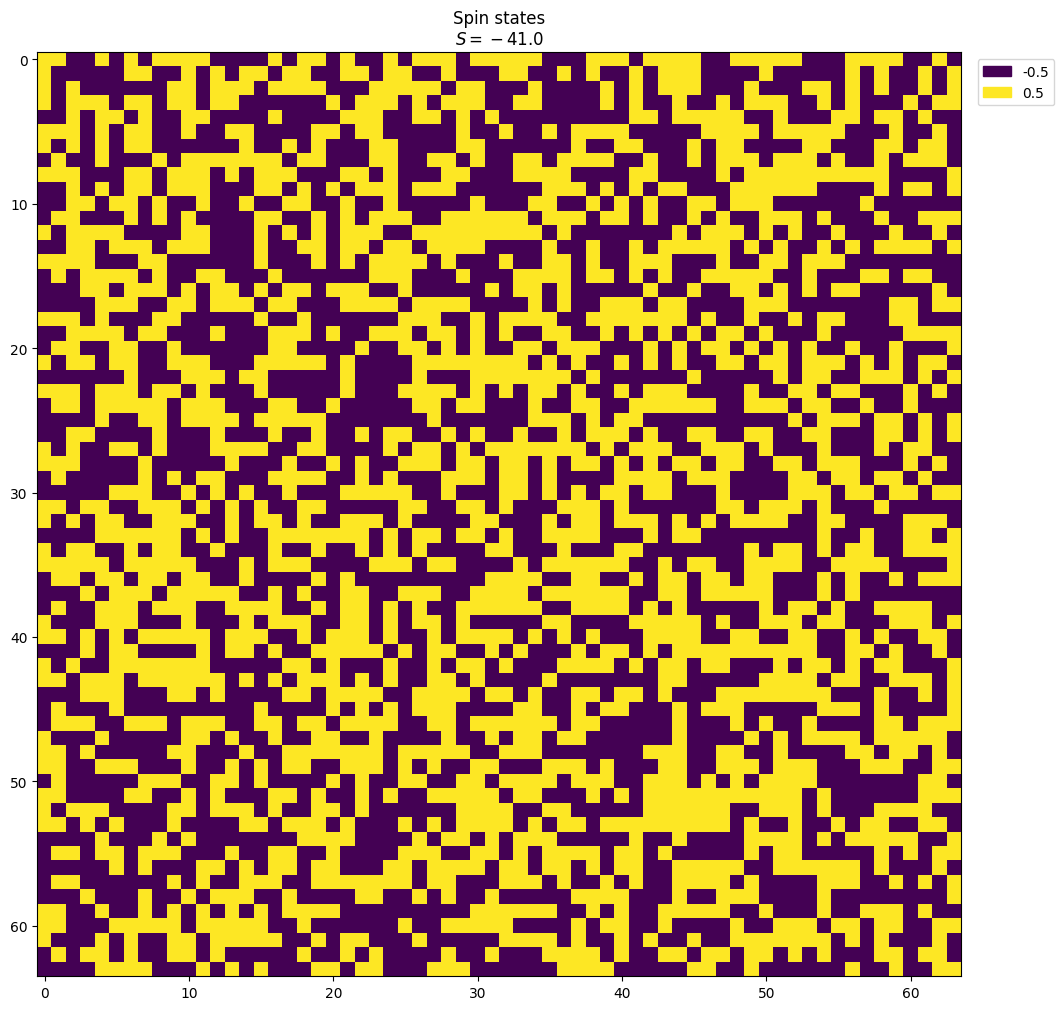

In [2]:
interaction_bilinear = 1.0
interaction_external_field = interaction_bilinear
nuclear_magnetic_moment = 1.0

temperatures = (
    np.geomspace(0.25, 5, 2**4) / constants.Boltzmann * interaction_bilinear
)

model = IsingModelND(
    2,
    size=64,
    spin=1 / 2,
    interaction_bilinear=interaction_bilinear,
    interaction_external_field=interaction_external_field,
    nuclear_magnetic_moment=nuclear_magnetic_moment,
)
model.initial_state.plot()

steps_per_state = int(3e3)
num_states = 25
states = [model.initial_state.copy() for n in range(len(temperatures))]
all_states = [list(state.copy() for state in states)]
print(f"Doing {steps_per_state * num_states * len(temperatures)} MCMC steps")

for n in tqdm(range(num_states)):
    model.run_steps(states, steps_per_state, temperatures, bc_mode="periodic")
    all_states.append([state.copy() for state in states])

end_magnetisations = [model.get_magnetisation(state) for state in all_states[-1]]

for i, mag in enumerate(end_magnetisations):
    print(f"{i}: {mag:.2f}")

In [3]:
# temperature_n = 8
# @interact(value=0, min=0, max=len(all_states))
# def update(i=(0, len(all_states) - 1)):

#     all_states[i][temperature_n].plot()

In [4]:
# End states


@interact(value=0, min=0, max=len(temperatures))
def update(i=(0, len(temperatures) - 1)):
    all_states[-1][i].plot()

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

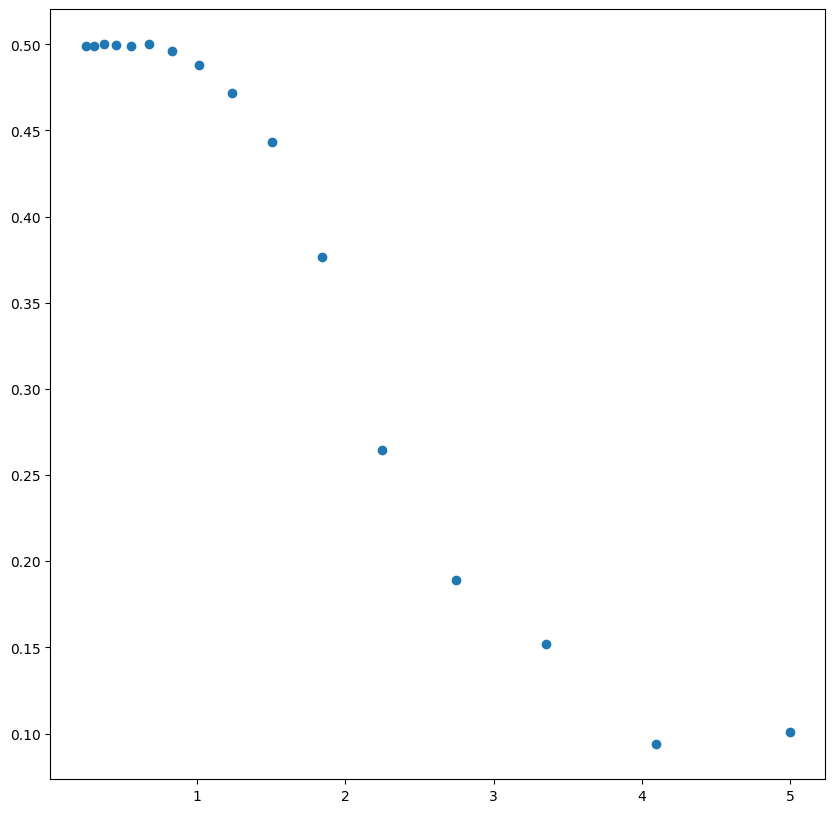

In [5]:
plt.figure()
x = np.array(temperatures * constants.Boltzmann / interaction_bilinear)
y = [model.get_magnetisation(state) for state in all_states[-1]]

plt.scatter(x, y)

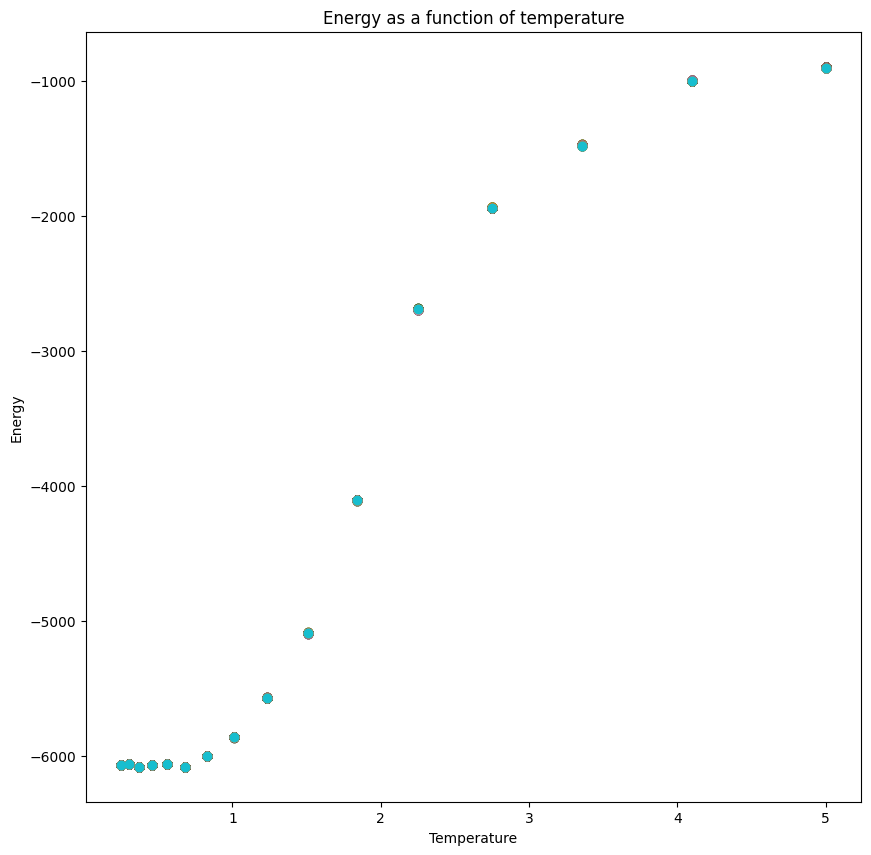

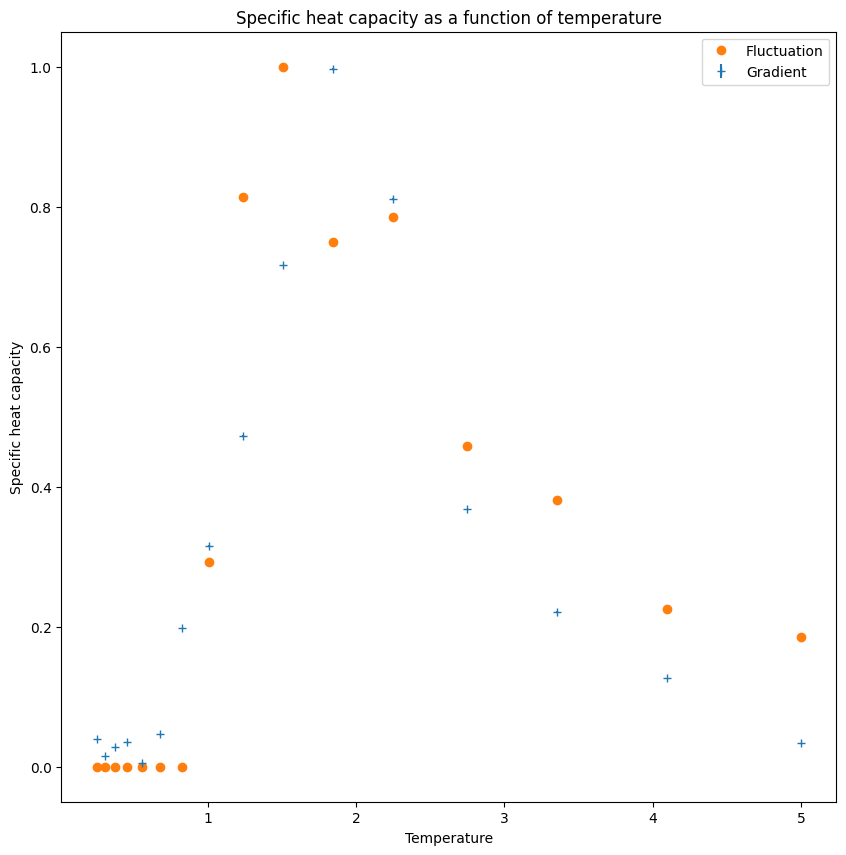

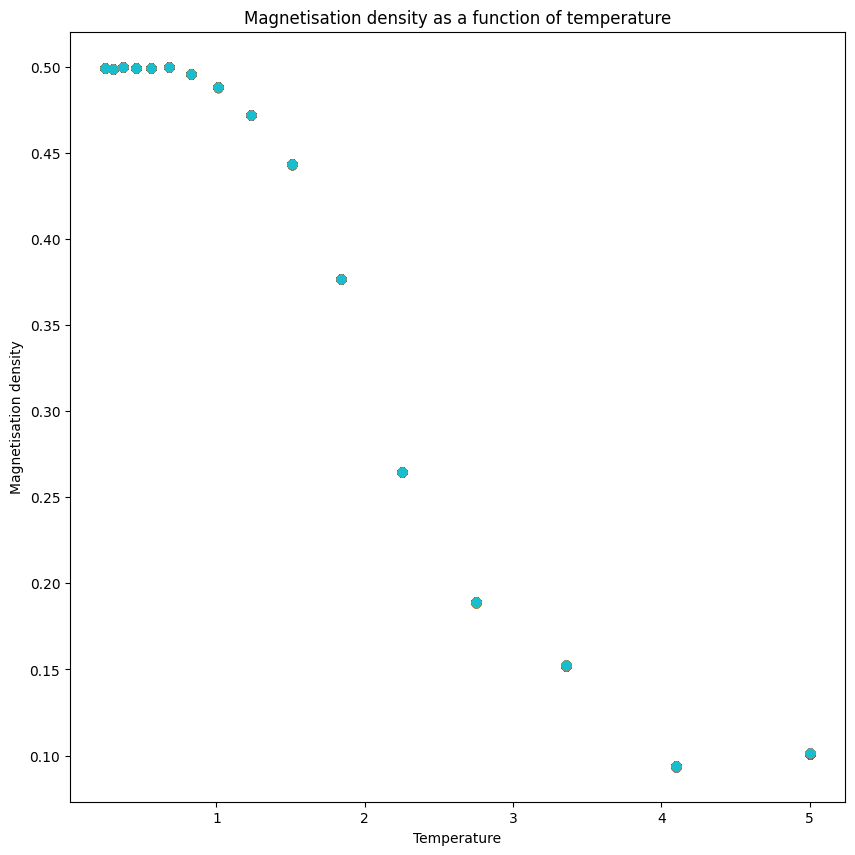

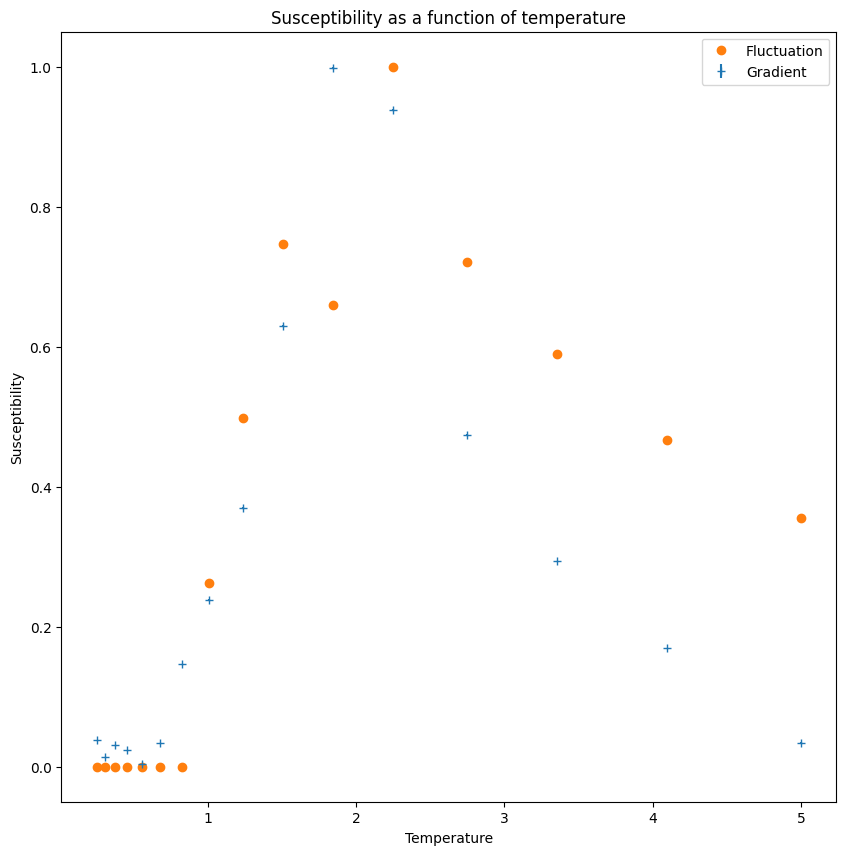

In [6]:
t = np.array(temperatures * constants.Boltzmann / interaction_bilinear)

equilibrium_steps = 500
equilibrium_properties = model.get_equilibrium_energies_and_magnetisations(
    states, equilibrium_steps, temperatures
)

energies = equilibrium_properties[:, :, 0]
magnetisation_densities = equilibrium_properties[:, :, 1]

heat_cap_gradient = np.abs(np.gradient(energies, t, axis=0))
heat_cap_gradient = heat_cap_gradient / heat_cap_gradient.max()
heat_cap_gradient_std = heat_cap_gradient.std(axis=1)

energies_std = energies.std(axis=1)
heat_cap_fluctuation = np.square(energies_std) / (constants.Boltzmann * np.square(t))
heat_cap_fluctuation = heat_cap_fluctuation / heat_cap_fluctuation.max()

susceptibilities_gradient = np.abs(np.gradient(magnetisation_densities, t, axis=0))
susceptibilities_gradient = susceptibilities_gradient / susceptibilities_gradient.max()
susceptibilities_gradient_std = susceptibilities_gradient.std(axis=1)

magnetisation_densities_std = magnetisation_densities.std(axis=1)
susceptibilities_fluctuation = np.square(magnetisation_densities_std) / (
    constants.Boltzmann * np.square(t)
)
susceptibilities_fluctuation = (
    susceptibilities_fluctuation / susceptibilities_fluctuation.max()
)

plt.figure()
plt.title("Energy as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Energy")
plt.plot(t, energies, "o")

plt.figure()
plt.title("Specific heat capacity as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Specific heat capacity")
plt.errorbar(
    t, heat_cap_gradient[:, 0], heat_cap_gradient_std, fmt="+", label="Gradient"
)
plt.plot(t, heat_cap_fluctuation, "o", label="Fluctuation")
plt.legend()

plt.figure()
plt.title("Magnetisation density as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Magnetisation density")
plt.plot(t, magnetisation_densities, "o")

plt.figure()
plt.title("Susceptibility as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Susceptibility")
plt.errorbar(
    t,
    susceptibilities_gradient[:, 0],
    susceptibilities_gradient_std,
    fmt="+",
    label="Gradient",
)
plt.plot(t, susceptibilities_fluctuation, "o", label="Fluctuation")
plt.legend()

In [8]:
heat_cap_gradient.shape

(16, 500)